## Load normalized data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import models
from keras import layers

normalized_data = pd.read_csv("normalized_data.csv", index_col=0)
normalized_data

Using TensorFlow backend.


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Mr,Miss,Mrs
PassengerId,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,1.0,NaN,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1306,NaN,0.0,0.484795,0.0,0.000000,0.212559,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1307,NaN,1.0,0.478512,0.0,0.000000,0.014151,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


## Counting empty values

In [2]:
empty_values = [(label, normalized_data[label].isnull().sum()) for label in normalized_data.columns.values]
sorted(empty_values, reverse=True, key=lambda tup: tup[1])

[('Survived', 418),
 ('Age', 263),
 ('Pclass', 0),
 ('SibSp', 0),
 ('Parch', 0),
 ('Fare', 0),
 ('female', 0),
 ('male', 0),
 ('C', 0),
 ('Q', 0),
 ('S', 0),
 ('Mr', 0),
 ('Miss', 0),
 ('Mrs', 0)]

## Separate samples with and without age

In [3]:
samples_with_age = normalized_data[normalized_data.Age.notna()]
samples_without_age = normalized_data[normalized_data.Age.isna()]

## Creating model for age prediction

In [4]:
x_train_age = samples_with_age.drop(["Age", "Survived"], axis=1).values
y_train_age = samples_with_age["Age"].values

model = models.Sequential()
model.add(layers.Dense(12, activation="relu", input_shape=(12,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["mae"])

history = model.fit(x_train_age,
                    y_train_age,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2)


Train on 836 samples, validate on 210 samples
Epoch 1/100
836/836 [==============================] - 0s 344us/step - loss: 0.1678 - mae: 0.3157 - val_loss: 0.0509 - val_mae: 0.1804
Epoch 2/100
836/836 [==============================] - 0s 135us/step - loss: 0.0895 - mae: 0.2349 - val_loss: 0.0361 - val_mae: 0.1423
Epoch 3/100
836/836 [==============================] - 0s 134us/step - loss: 0.0601 - mae: 0.1938 - val_loss: 0.0345 - val_mae: 0.1407
Epoch 4/100
836/836 [==============================] - 0s 148us/step - loss: 0.0491 - mae: 0.1737 - val_loss: 0.0291 - val_mae: 0.1313
Epoch 5/100
836/836 [==============================] - 0s 173us/step - loss: 0.0420 - mae: 0.1596 - val_loss: 0.0335 - val_mae: 0.1408
Epoch 6/100
836/836 [==============================] - 0s 174us/step - loss: 0.0373 - mae: 0.1507 - val_loss: 0.0304 - val_mae: 0.1339
Epoch 7/100
836/836 [==============================] - 0s 137us/step - loss: 0.0355 - mae: 0.1451 - val_loss: 0.0263 - val_mae: 0.1256
Epoch 8/1

Epoch 61/100
836/836 [==============================] - 0s 128us/step - loss: 0.0240 - mae: 0.1203 - val_loss: 0.0204 - val_mae: 0.1163
Epoch 62/100
836/836 [==============================] - 0s 120us/step - loss: 0.0237 - mae: 0.1191 - val_loss: 0.0204 - val_mae: 0.1172
Epoch 63/100
836/836 [==============================] - 0s 115us/step - loss: 0.0229 - mae: 0.1182 - val_loss: 0.0210 - val_mae: 0.1172
Epoch 64/100
836/836 [==============================] - 0s 125us/step - loss: 0.0237 - mae: 0.1176 - val_loss: 0.0207 - val_mae: 0.1188
Epoch 65/100
836/836 [==============================] - 0s 124us/step - loss: 0.0235 - mae: 0.1179 - val_loss: 0.0205 - val_mae: 0.1179
Epoch 66/100
836/836 [==============================] - 0s 115us/step - loss: 0.0236 - mae: 0.1191 - val_loss: 0.0207 - val_mae: 0.1193
Epoch 67/100
836/836 [==============================] - 0s 116us/step - loss: 0.0230 - mae: 0.1176 - val_loss: 0.0212 - val_mae: 0.1173
Epoch 68/100
836/836 [==========================

## Drwing plots for age prediction

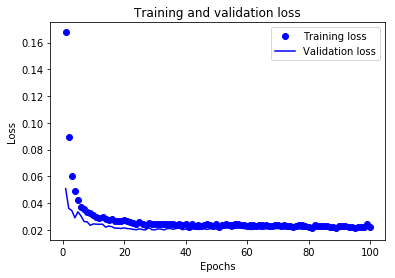

In [5]:
history_dict = history.history
history_dict.keys()
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Evaluate results for age prediction

In [6]:
results_age = model.predict(samples_without_age.drop(["Survived", "Age"], axis=1))
samples_without_age.loc[:,"Age"] = results_age
samples_without_age

/home/victor/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Mr,Miss,Mrs
PassengerId,,,,,,,,,,,,,,
6,0.0,1.0,0.385470,0.0,0.000000,0.016510,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
18,1.0,0.5,0.394553,0.0,0.000000,0.025374,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
20,1.0,1.0,0.360635,0.0,0.000000,0.014102,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
27,0.0,1.0,0.347394,0.0,0.000000,0.014102,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
29,1.0,1.0,0.287212,0.0,0.000000,0.015379,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.287210,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1302,NaN,1.0,0.287210,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1305,NaN,1.0,0.347394,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


## Save data

In [7]:
normalized_data_with_predicted_age = pd.concat([samples_with_age, samples_without_age])
normalized_data_with_predicted_age.to_csv("normalized_data_with_predicted_age.csv", index=True)
normalized_data_with_predicted_age

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S,Mr,Miss,Mrs
PassengerId,,,,,,,,,,,,,,
1,0.0,1.0,0.271174,0.2,0.000000,0.014151,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.472229,0.2,0.000000,0.139136,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.321438,0.0,0.000000,0.015469,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.434531,0.2,0.000000,0.103644,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.0,1.0,0.434531,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,NaN,1.0,0.287210,0.0,0.000000,0.015070,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1302,NaN,1.0,0.287210,0.0,0.000000,0.015127,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1305,NaN,1.0,0.347394,0.0,0.000000,0.015713,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


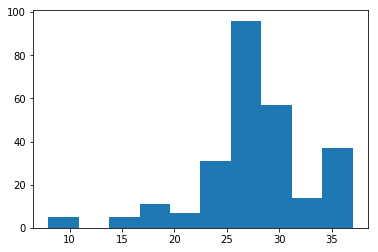

In [8]:
import matplotlib.pyplot as plt

plt.hist(results_age*80)
plt.show()

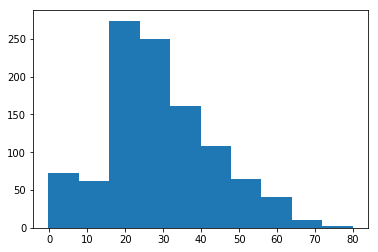

In [9]:
import matplotlib.pyplot as plt

plt.hist(samples_with_age.Age*80)
plt.show()
